# Early Readmission Prediction for the five publically reported CMS diseases

### Background and Goal

Nearly 15 percent of hospitalized patients are readmitted within 30 days of discharge, the cost of unplanned readmissions is 15 to 20 billion dollars annually. In an effort to reduce the readmission rate and such associated costs. Center of Medicaid and Medicare Systems (CMS) began to publicly report 30-day early readmission for acute myocardial infarction (AMI), Heart Failure (HF), and pneumonia (PN) in 2009 and in 2014 they added Chronic obstructive pulmonary disease (COPD) and ischemic stroke (IS) on the CMS Hospital Compare website. Additionally, the Secretary of the Department of Health and Human Services (HHS) as per the Affordable Care Act established a Hospital Readmissions Reduction Program (HRRP) to reduce payments to hospitals for excess readmissions starting the Fiscal Year 2013. Therefore, Hospitals started to focus their efforts to reduce the early readmissions rate not only for the financial penalty but also for their effectiveness reputability. Identification of patients with high risk for early readmission at the time of discharge can help taking necessary measures to reduce such risk. 
We aim to develop a deep learning algorithm to predict early readmissions for individual patients based on their EHR available data. Such an algorithm can be later utilized as a clinical decision support system (CDSS) to provide a recommendation at the patient discharge consolidation to improve the quality of the provided healthcare.

### Task

We want to demonstrate the feasibility of different deep learning architectures mainly Recurrent Neural Networks(RNN) for patient early readmission prediction for patients with one of the five publically reported CMS diseases (AMI, HF, PN, COPD, IS) and compare against other baseline models like Logistic Regression (LR) and Random Forrest (RF). 

### Dataset

We will use the Cerner HealthFacts® database and we will extract all patients with at least two inpatient encounters and has reported any of the CMS 5 publically reported diseases. We will follow the CMS definition of early in-hospital readmission within 30 days. We will exclude any planned readmissions based on the encounter admission source or the index encounter discharge disposition, as well as recurring or transfer encounters. We define our cases as patients who readmitted within 30 days of their previous hospitalization and we define our controls as patients who also get readmitted but after at least 90 days.  On an initial exploration our cohort is composed of 161,738 cases and 178,926 controls and for a sample hospital, we will have 5897 cases and 4757 controls. We plan to use all available patient information including encounter administration level information, demographics, diagnosis, medication, procedures, clinical events, and laboratory results.
Deliverables
Reproducible and documented computational pipelines trained and tested on the dataset. 
A comparative evaluation of the performance of different baseline models

### Metrics
We will use the ROC AUC for the models’ performance comparison.


In [ ]:
'''
### Notes from the class

--- use argparse create automtic help versus sys.arg
'''

#### Required Tools and Packages
---------------------------------
We mostly use scikit-learn for baseline machine learning, plotly and matpoltlib for visualization within ipython notebooks, but we also use Tableau aside of it.

For deep learning we rely on Pytorch framework (v1), GPU enabling accelerate the computational performance,and for the full set model trainings we might need to utilize the Pytorch DataParallel functionality for parallel GPU computing. 

In [3]:
### Tools and Packages
##Basics
import pandas as pd
import numpy as np
import sys, random
import math
try:
    import cPickle as pickle
except:
    import pickle
import string
import re
import os
import time


## ML and Stats 
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import sklearn.metrics as m
import sklearn.linear_model  as lm
from lifelines.estimation import KaplanMeierFitter
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import export_graphviz
import statsmodels.formula.api as sm
import patsy
from scipy import stats

## Visualization
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.graph_objs import *
from IPython.display import HTML

## DL Framework
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.autograd import Variable
from torch import optim



###GPU enabling and device allocation
use_cuda = torch.cuda.is_available()
torch.cuda.set_device(1)



## Data extraction


##### Pseudo-code for Data Extraction
a.	Inpatient encounter at acute care hospital that last for at least 24 hours (i.e. discharged_dt_tm - admitted_dt_tm > 24hrs)

b.	Age >=18

c.	First inpatient encounter with any of the above diagnosis will be considered the index encounter

d.	The next inpatient encounter regardless the hospital or the diagnoses i.e. (any inpatient admission) will be considered the readmission encounter, need to be at least 1 day apart from the index encounter

e.	Cases are patients readmitted less than 30 days after the index encounter discharge date i.e. (readmission encounter admitted_dt_tm - index encounter discharged_dt_tm < 30 days and >= 1 day), and controls (readmission encounter admitted_dt_tm - index encounter discharged_dt_tm < 30 days

f.	For data quality issue you might face the case of :

    a.	missing admission dates --- need to exclude those encounters from the case scenario identification as we normally nvl null admission with the discharged_dt_tm and hence the duration of the encounter become 0 (less than 1 day).
    
    b.	encounters dates / duration overlapping ---- so you might find (readmission encounter admitted_dt_tm - index encounter discharged_dt_tm < 1 or 0). So, we exclude those patients from the study for simplicity.
    
g.	Different encounters need to be at least 1 day apart.


2.	ICD Code:

1)	Reference: 
a.	ICD-9-CM: 2016 Condition-Specific Measures Updates and Specifications Report Hospital-Level 30-Day Risk-Standardized Readmission Measures 
b.	ICD-10-CM: 2018 Condition-Specific Measures Updates and Specifications Report Hospital-Level 30-Day Risk-Standardized Readmission Measures 
c.	Links:  https://www.qualitynet.org/dcs/ContentServer?c=Page&pagename=QnetPublic%2FPage%2FQnetTier4&cid=1219069855841 


2)	Code:
a.	Pneumonia:
a)	ICD-9-CM: 480.x, 481, 482.x, 483.x, 485, 486, 487.0, 488.11, 507.x 
b)	ICD-10-CM: A48.1, J10.0x, J11.0x, J12.x, J13, J14, J15.x, J16.x, J69.x, J18.x except J18.2 

b.	Heart Failure:
a)	ICD-9-CM: 402.01, 402.11, 402.91, 404.01, 404.03, 404.11, 404.13, 404.91, 404.93, 428.x
b)	ICD-10-CM: I13.0, I13.2, I11.0, I50.x
c.	Stroke:
a)	ICD-9-CM: 433.x1, 434.x1, 436
b)	ICD-10-CM: I63.x, I67.89
d.	Acute Myocardial Infarction (AMI):
a)	ICD-9-CM: 410.x except 410.x2 which refer to subsequent episode of care
b)	ICD-10-CM: I21.x
e.	COPD:
a)	ICD-9-CM: 491.21, 491.22, 491.8, 491.9, 492.8, 493.2x, 496
b)	ICD-10-CM: J41.8, J42, J43.x, J44.0, J44.1, J44.9


## Data Preprocessing

###### It is highly recommended to preprocess the data using code available on the Pre-processing folder and load the processed data here .
Otherwise you can use the code below

In [ ]:
##### Need to call process_cerner_noMatch.py here to preprocess the raw data to pickled lists if not there

try:
    train_sl= pickle.load(open('/data/projects/py_ehr_2/Data/readm_new_h143_90_tp.train', 'rb'), encoding='bytes')
    test_sl= pickle.load(open('/data/projects/py_ehr_2/Data/readm_new_h143_90_tp.test', 'rb'), encoding='bytes')
    valid_sl= pickle.load(open('/data/projects/py_ehr_2/Data//readm_new_h143_90_tp.valid', 'rb'), encoding='bytes')
    # types dictionary
    types_d=pickle.load(open('/data/projects/Readm/pdata/readm_new_h143_90.types.all', 'rb'), encoding='bytes')
    
except:
     import process_cerner_sample_noMatch as preprocess1

types_d_rev = dict(zip(types_d.values(),types_d.keys()))
input_size_1=[len(types_d_rev)+1]
print (len(train_sl),len(valid_sl),len(test_sl))
print(input_size_1)


In [5]:
preprocess1  <case_file> <control_file> <previous_types/NA> <outputfile>

<module 'process_cerner_sample_noMatch' from '/data/projects/py_ehr_mod/process_cerner_sample_noMatch.py'>

# Baseline Analysis

#### Data Loading and Preparation

In [8]:
### A sample one hospital data, this is preprocessed data 

train_sl= pickle.load(open('../pdata/readm_new_h143_90_tp.train', 'rb'), encoding='bytes')
test_sl= pickle.load(open('../pdata/readm_new_h143_90_tp.test', 'rb'), encoding='bytes')
valid_sl= pickle.load(open('../pdata/readm_new_h143_90_tp.valid', 'rb'), encoding='bytes')
print (len(train_sl),len(valid_sl),len(test_sl))
input_size_1=[52007]

# types dictionary
types_d=pickle.load(open('../pdata/readm_new_h143_90.types.all', 'rb'), encoding='bytes')
types_d_rev = dict(zip(types_d.values(),types_d.keys()))
#input_size_1=[len(types_d_rev)+1]
input_size_1=[max(types_d.values())+1]
print(input_size_1)

7459 1065 2130
[9057]


In [10]:
##### Data conversion to onehot matrices for Logestic Regression and may be Random Forest Basic test
pts_tr=[]
labels_tr=[]
features_tr=[]
for pt in train_sl:
    pts_tr.append(pt[0])
    labels_tr.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_tr.append(x)
      
pts_t=[]
labels_t=[]
features_t=[]
for pt in test_sl:
    pts_t.append(pt[0])
    labels_t.append(pt[1])
    x=[]
    for v in pt[-1]:
        x.extend(v[-1])
    features_t.append(x)

    
mlb = MultiLabelBinarizer(classes=range(input_size_1[0])[1:])
nfeatures_tr = mlb.fit_transform(features_tr)
nfeatures_t= mlb.fit_transform(features_t)


In [11]:
### Model Evaluation
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    pred_prob=model.predict_proba(test_features)
    auc_p=roc_auc_score(test_labels,pred_prob[:,1])
    print('Model Performance')
    print('AUC = {:0.2f}%.'.format(auc_p*100))
    return test_labels,pred_prob[:,1]

In [12]:
### ROC curve plotting

def plot_roc_curve(label,score):
    fpr, tpr, ths = m.roc_curve(label, score) ### If I round it gives me an AUC of 64%
    roc_auc = m.auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange',lw=3, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.ylabel('Sensitivity')
    plt.xlabel('1-Specificity')
    plt.title('ROC')
    plt.legend(loc="lower right")
    plt.show()

In [13]:
#### Interactive Plot showing the deep learning model training AUC change over epochs

def plot_DLauc_perf(train_auc_allepv,test_auc_allepv,valid_auc_allepv,title_m):
    epochs=100
    train_auc_fg= go.Scatter(x= np.arange(epochs), y=train_auc_allepv, name='train')
    test_auc_fg= go.Scatter(x= np.arange(epochs), y=test_auc_allepv, name='test')
    valid_auc_fg= go.Scatter(x= np.arange(epochs), y=valid_auc_allepv, name='valid')
    valid_max = max(valid_auc_allepv)
    test_max = max(test_auc_allepv)
    data = [train_auc_fg,test_auc_fg,valid_auc_fg]
    layout = go.Layout(xaxis=dict(dtick=1),title=title_m)
    layout.update(dict(annotations=[go.layout.Annotation(text="Max Valid", x=valid_auc_allepv.index(valid_max), y=valid_max)]))
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, filename=title_m)

In [14]:
### for tracking computational timing
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


In [15]:
### DL RNN Model training 

def run_dl_model(ehr_model,train_sl,valid_sl,test_sl,bmodel_pth,bmodel_st):

    ##Hyperparameters -- Fixed for testing purpose
    epochs = 100
    l2 = 0.0001
    lr = 0.01
    eps = 1e-4
    w_model='RNN'
    optimizer = optim.Adamax(ehr_model.parameters(), lr=lr, weight_decay=l2 ,eps=eps)   

    ##Training epochs
    bestValidAuc = 0.0
    bestTestAuc = 0.0
    bestValidEpoch = 0
    train_auc_allep =[]
    valid_auc_allep =[]
    test_auc_allep=[]  
    for ep in range(epochs):
        start = time.time()
        current_loss, train_loss = TVT.train(train_sl, model= ehr_model, optimizer = optimizer, batch_size =128)
        avg_loss = np.mean(train_loss)
        train_time = timeSince(start)
        eval_start = time.time()
        Train_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = train_sl, which_model = w_model, batch_size = 128)
        valid_auc, y_real, y_hat  = TVT.calculate_auc(model = ehr_model, data = valid_sl, which_model = w_model, batch_size = 128)
        TestAuc, y_real, y_hat = TVT.calculate_auc(model = ehr_model, data = test_sl, which_model = w_model, batch_size = 128)
        eval_time = timeSince(eval_start)
        print ("Epoch: " ,str(ep) ," Train_auc :" , str(Train_auc) , " , Valid_auc : " ,str(valid_auc) , " ,& Test_auc : " , str(TestAuc) ," Avg Loss: " ,str(avg_loss), ' , Train Time :' , str(train_time) ,' ,Eval Time :' ,str(eval_time))
        train_auc_allep.append(Train_auc)
        valid_auc_allep.append(valid_auc)
        test_auc_allep.append(TestAuc)

        if valid_auc > bestValidAuc: 
            bestValidAuc = valid_auc
            bestValidEpoch = ep
            bestTestAuc = TestAuc
            ###uncomment the below lines to save the best model parameters
            best_model = ehr_model
            torch.save(best_model, bmodel_pth)
            torch.save(best_model.state_dict(), bmodel_st)
        if ep - bestValidEpoch >5: break
    print( 'bestValidAuc %f has a TestAuc of %f at epoch %d ' % (bestValidAuc, bestTestAuc, bestValidEpoch))
    return train_auc_allep,valid_auc_allep,test_auc_allep

### Logistic Regression

/home/lgindybekhet/.local/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Model Performance
AUC = 68.19%.


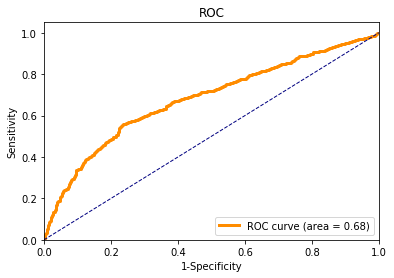

Highly contributing factors based on coefficients: 
870 1.4327831054812148 b'D_16312'
1027 -1.2175592938188224 b'D_7374'
1306 1.3082165332769324 b'D_16096'
1702 1.4244627069838702 b'D_5590'
1704 -1.2811855785882438 b'D_7767'
1753 -1.2237770582070084 b'D_14857'
1810 1.2127095662926224 b'D_10359'
2171 -1.3765387239383837 b'Age_8'
2423 1.411843306648128 b'M_SODIUM CITRATE'
2455 1.2457002683763267 b'D_16357'
2484 1.290995826078115 b'D_853'
2549 -1.283826175438615 b'D_6661'
2578 1.5232369198766638 b'D_990'
3075 1.3007464015553634 b'D_512'
3257 1.2994523105230258 b'D_7355'
3612 -1.2790395654374211 b'D_1531'
3670 1.2087742902514997 b'D_15173'
3792 -1.2766749959199761 b'D_14411'
3906 1.2033291331647253 b'D_10643'
4151 -1.328845942411621 b'D_16387'
4221 -1.3269166700727617 b'D_14887'
4315 1.2334725242402487 b'D_10654'
4710 1.3064383028717754 b'M_LVP SOLUTION WITH POTASSIUM'
4786 -1.8074249929705968 b'D_7766'
5422 -1.2741952151638185 b'D_10143'
5440 1.3445762901678118 b'D_7470'
6503 1.5482152564

In [18]:
EHR_LR= lm.LogisticRegression()
EHR_LR.fit(nfeatures_tr, labels_tr)
labels,scores=evaluate(EHR_LR,nfeatures_t, labels_t)

plot_roc_curve(labels,scores)

print ("Highly contributing factors based on coefficients: ")
f_imp=EHR_LR.coef_
## top contributing factors in both directions
for i,j in enumerate(f_imp[0].tolist()):
    if j>1.2 or j<-1.2:
        print (i+1,j,types_d_rev[i+1])


### RNN

In [20]:
### Import the RNN model definition that include the definition of the embedding architucture and different variations of RNN architictures
### we will use a very basic GRU layer for this primary analysis
import model_HPS1 as model 
import TrVaTe as TVT 

ehr_model = model.EHR_RNN(input_size_1, embed_dim=128, hidden_size=128, n_layers=1, dropout_r=0., cell_type='GRU', bii=True , time=True)
if use_cuda: ehr_model = ehr_model.cuda()    

### Model training 
train_auc_allep,valid_auc_allep,test_auc_allep=run_dl_model(ehr_model,train_sl,valid_sl,test_sl,'Readm_test.pth','Readm_test.st')

Epoch:  0  Train_auc : 0.7408903063875367  , Valid_auc :  0.7099014193621754  ,& Test_auc :  0.6930175154093985  Avg Loss:  0.7005350611426613  , Train Time : 0m 54s  ,Eval Time : 1m 14s
Epoch:  1  Train_auc : 0.8399292437576891  , Valid_auc :  0.7264405069049091  ,& Test_auc :  0.7097633518222196  Avg Loss:  0.603762301531705  , Train Time : 0m 53s  ,Eval Time : 1m 16s
Epoch:  2  Train_auc : 0.9095683338747054  , Valid_auc :  0.7123748196478958  ,& Test_auc :  0.7070680524959997  Avg Loss:  0.5338196104223077  , Train Time : 0m 55s  ,Eval Time : 1m 15s
Epoch:  3  Train_auc : 0.9715641947398981  , Valid_auc :  0.7236010718067905  ,& Test_auc :  0.7209060152264231  Avg Loss:  0.43365235057744117  , Train Time : 0m 53s  ,Eval Time : 1m 16s
Epoch:  4  Train_auc : 0.9961449947061803  , Valid_auc :  0.7222080072780515  ,& Test_auc :  0.7132192547519787  Avg Loss:  0.31647979264909565  , Train Time : 0m 52s  ,Eval Time : 1m 15s
Epoch:  5  Train_auc : 0.998885500166045  , Valid_auc :  0.70285

In [22]:
#### Interactive Plot showing the model training AUC change over epochs
plot_DLauc_perf(train_auc_allep,test_auc_allep,valid_auc_allep,'Readm_GRU_Auc')